In this assignment, you will implement a logistic regression model from scratch for binary classification.

Libraries

In [226]:
import pandas as pd
import numpy as np
from abc import ABC, abstractmethod 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import time
import math

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, log_loss
import matplotlib.pyplot as plt


from sklearn.datasets import load_wine

Pulling Data Set In

In [227]:
# loading wine data in from sklearn datasets
wine = load_wine()

# converting data into pandas df, only including feature columns
df = pd.DataFrame(wine.data, columns=wine.feature_names)

Data Prep

In [228]:
# creating target variable
df['target'] = wine.target

# filtering to only include classes 0 and 1 for binary classification
df_binary = df[df['target'].isin([0, 1])]

df_binary.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [229]:
# getting columns names in list
columns=wine.feature_names

# feature values
X = df_binary[columns].values

# target value
y = df_binary["target"].values

In [230]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [231]:
# initiaing list to store performance metrics
performance_metrics = []

Base Class

In [232]:
class Model(ABC):
    @abstractmethod
    def fit(self, X, y):
        pass
    @abstractmethod
    def predict(self, X):
        pass
    @abstractmethod
    def cost_function(self, y_true, y_pred, eps=1e-15):
        pass

log regression

In [233]:
class LogisticRegressionManual(Model):
    def __init__(self, lr, epochs, fit_intercept=True):
        # Initialize coefficients (weights for features) as None
        self.coef_ = None
        # Initialize intercept (bias term) to 0
        self.intercept_ = 0.0
        # Whether to include an intercept in predictions
        self.fit_intercept = fit_intercept
        # Learning rate for gradient descent
        self.lr = lr
        # Number of iterations for training
        self.epochs = epochs
    
    def sigmoid(self, z):
        # Sigmoid function to map any real value to (0, 1) if y > .5, 1 else 0
        # z is linear combination of features and weights
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        #vectorize
        X = np.array(X)
        y = np.array(y)

        # Number of samples and features
        n_samples, n_features = X.shape

        # Initialize coefficients (weights) to zeros
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

        # Gradient descent for specified number of epochs
        for _ in range(self.epochs):
            # Linear model: weighted sum of inputs plus intercept
            # z = X * weights + intercept
            linear_model = np.dot(X, self.coef_) + self.intercept_
            # Apply sigmoid to convert linear scores to predicted probabilities
            y_predicted = self.sigmoid(linear_model)

            # Compute gradients for weights and intercept -- 1/m * X.T * (y_pred - y)
            # greadient wrt to weights
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            # gradient wrt to intercept
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update weights and intercept using gradients (opposite dir of gradient) and learning rate
            self.coef_ -= self.lr * dw
            self.intercept_ -= self.lr * db
    
    def predict_proba(self, X):
        # predict probabilities using learned coefficients and intercept, returns 0<val<1
        linear_model = np.dot(X, self.coef_) + self.intercept_
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=.5):
        # probabilities to get predicted classes 0 or 1 based on threshold
        # if prob > threshold, class 1 else class 0
        # default threshold is .5
        y_predicted_probs = self.predict_proba(X)
        return np.where(y_predicted_probs >= threshold, 1, 0)
    
    def cost_function(self, y_true, y_pred, eps=1e-15):
        n = len(y_true)
        total_loss = 0.0
        for yt, yp in zip(y_true, y_pred):
            # Clamp predicted probability to avoid log(0)
            yp = min(max(yp, eps), 1 - eps)

            # Correct log loss formula
            total_loss += yt * math.log(yp) + (1 - yt) * math.log(1 - yp)

        return -total_loss / n
     

applying logistric regression class

In [234]:
# Logistic Regression
log_reg = LogisticRegressionManual(
    lr = .05, 
    epochs = 1000, 
    fit_intercept=True
)

#starting timer
start = time.time()

#fitting model
log_reg.fit(X_train, y_train)

#ending timer
end = time.time()

#predicting target variable
y_pred_gd = log_reg.predict(X_test)

y_pred_probabilites = log_reg.predict_proba(X_test)

#appending perf metrics for model intno perf metric list
performance_metrics.append(
    {
        "Model": "Logistic Regression",
        "Intercept": log_reg.intercept_,
        "Coefficients": log_reg.coef_,
        "Fit Time": end - start,
        "Log Loss": log_reg.cost_function(y_test, y_pred_probabilites)
    }
)

/var/folders/qb/_bb76w111b9b_z80kl4xl2fc0000gp/T/ipykernel_62611/408253085.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Sklearn

In [235]:
# Scikit-learn Logistic Regression
clf = LogisticRegression(
    fit_intercept=True, 
    random_state=0, 
    max_iter=1000
)

# Start timer
start = time.time()

# Fit on training set
clf.fit(X_train, y_train)

# End timer
end = time.time()

# Predictions (on test set)
y_pred_clf = clf.predict(X_test)

# Predicted probabilities (on test set)
y_pred_prob_clf = clf.predict_proba(X_test)

# Append performance metrics
performance_metrics.append(
    {
        "Model": "Logistic Regression (Scikit-learn)",
        "Intercept": clf.intercept_.tolist(),
        "Coefficients": clf.coef_.flatten().tolist(),
        "Log Loss": log_loss(y_test, y_pred_prob_clf),
        "Fit Time": end - start
    }
)


In [236]:
# convert list of dicts into DataFrame
perf_table = pd.DataFrame(performance_metrics)

# show table
print(perf_table)

# if you want a nicer display in Jupyter
from IPython.display import display
display(perf_table)


                                Model             Intercept  \
0                 Logistic Regression              1.879101   
1  Logistic Regression (Scikit-learn)  [27.420063610983245]   

                                        Coefficients  Fit Time  Log Loss  
0  [17.55597877856017, 0.06572462854396002, 3.044...  0.015363  1.328445  
1  [-0.9485662786995305, -1.026466521788334, -0.8...  0.038945  0.021394  


,Model,Intercept,Coefficients,Fit Time,Log Loss
0,Logistic Regression,1.879101,"[17.55597877856017, 0.06572462854396002, 3.044...",0.015363,1.328445
1,Logistic Regression (Scikit-learn),[27.420063610983245],"[-0.9485662786995305, -1.026466521788334, -0.8...",0.038945,0.021394


Analyzing and Comparing Performance - Confusion matrix, Accuracy,  Precision, Recall, and ROC curve

In [237]:
# Confusion matrix
cm_manual = confusion_matrix(y_test, y_pred_gd)
cm_sklearn = confusion_matrix(y_test, y_pred_clf)

# Accuracy
acc_manual = accuracy_score(y_test, y_pred_gd)
acc_sklearn = accuracy_score(y_test, y_pred_clf)

# Precision
prec_manual = precision_score(y_test, y_pred_gd)
prec_sklearn = precision_score(y_test, y_pred_clf)

# Recall
recall_manual = recall_score(y_test, y_pred_gd)
recall_sklearn = recall_score(y_test, y_pred_clf)


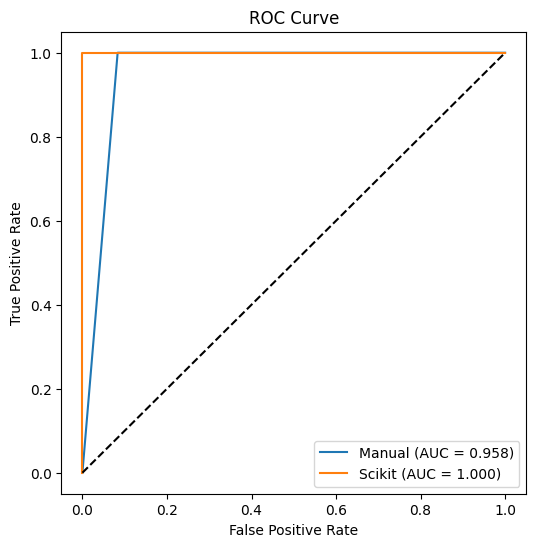

In [239]:
# ROC curve values (use y_test instead of y)
fpr_manual, tpr_manual, _ = roc_curve(y_test, y_pred_probabilites)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, y_pred_prob_clf[:, 1])  # positive class only

# AUC
roc_auc_manual = auc(fpr_manual, tpr_manual)
roc_auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

# Plotting ROC curves
plt.figure(figsize=(6,6))
plt.plot(fpr_manual, tpr_manual, label=f'Manual (AUC = {roc_auc_manual:.3f})')
plt.plot(fpr_sklearn, tpr_sklearn, label=f'Scikit (AUC = {roc_auc_sklearn:.3f})')
plt.plot([0,1], [0,1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [240]:
print("Manual Logistic Regression")
print("Confusion Matrix:\n", cm_manual)
print(f"Accuracy: {acc_manual:.3f}")
print(f"Precision: {prec_manual:.3f}")
print(f"Recall: {recall_manual:.3f}")

print("\nScikit-learn Logistic Regression")
print("Confusion Matrix:\n", cm_sklearn)
print(f"Accuracy: {acc_sklearn:.3f}")
print(f"Precision: {prec_sklearn:.3f}")
print(f"Recall: {recall_sklearn:.3f}")

Manual Logistic Regression
Confusion Matrix:
 [[11  1]
 [ 0 14]]
Accuracy: 0.962
Precision: 0.933
Recall: 1.000

Scikit-learn Logistic Regression
Confusion Matrix:
 [[12  0]
 [ 0 14]]
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


The Sklearn model performs better than the model i created. the sklearn model correctly identifies every instance.